## Potato Disease Classification


In [1]:
# import libraries
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 

2023-08-23 21:56:07.287522: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 21:56:07.731333: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 21:56:07.733681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 21:56:09.240533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# SET ALL THE CONSTANTS 
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 
EPOCHS = 7 


In [3]:
# IMPORT DATA INTO TENSORFLOW DATASET OBJECT 

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    seed=123, 
    shuffle=True, 
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

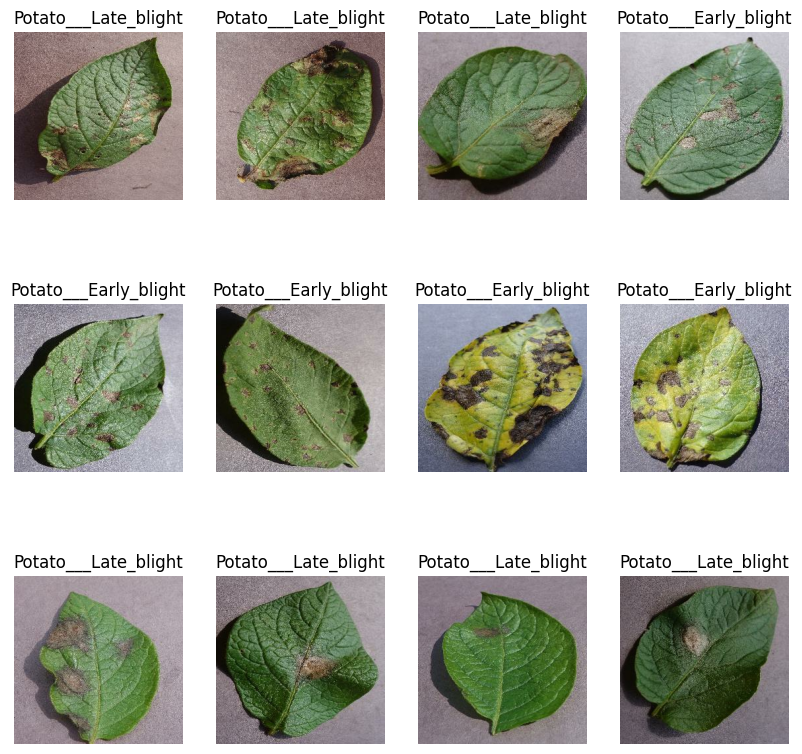

In [5]:
# VISUALIZE SOME OF THE IMAGES FROM OUR DATASET 
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

## Function to split Dataset 
Dataset should be bifurcated into 3 subsets, namely;
1. Training Dataset to be used while training 
2. Validation Dataset to be tested against while training 
3. Test Dataset to be tested against after we trained the model

In [6]:
len(dataset)

68

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_size = 0.1 
len(dataset) * val_size


6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(dataset)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset


In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## Building the Model


Creating a Layer for Resizing and Normalization

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation 
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.



In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
# APPLYING DATA AUGMENTATION TO TRAIN DATASET 
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## MODEL ARCHITECTURE 


In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 
model = models.Sequential([
    resize_and_rescale, 
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(2,2), activation='relu'),
    layers.MaxPool2D((2,2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
])


model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 63, 63, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 61, 61, 64)         

In [26]:
# COMPILING THE MODEL 

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
histroy = model.fit(
    train_ds, 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=7
)

Epoch 1/7


2023-08-23 21:44:30.623273: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-08-23 21:44:30.661789: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-08-23 21:44:30.686478: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-08-23 21:44:30.712830: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


54/54 [==============================] - 97s 2s/step - loss: 0.9082 - accuracy: 0.4983 - val_loss: 0.7877 - val_accuracy: 0.6042
Epoch 2/7
54/54 [==============================] - 92s 2s/step - loss: 0.6272 - accuracy: 0.7159 - val_loss: 0.6075 - val_accuracy: 0.7448
Epoch 3/7
54/54 [==============================] - 95s 2s/step - loss: 0.4976 - accuracy: 0.7847 - val_loss: 0.5588 - val_accuracy: 0.7812
Epoch 4/7
54/54 [==============================] - 94s 2s/step - loss: 0.4078 - accuracy: 0.8362 - val_loss: 0.3556 - val_accuracy: 0.8542
Epoch 5/7
54/54 [==============================] - 95s 2s/step - loss: 0.2802 - accuracy: 0.8929 - val_loss: 0.2746 - val_accuracy: 0.9062
Epoch 6/7
54/54 [==============================] - 101s 2s/step - loss: 0.2449 - accuracy: 0.9109 - val_loss: 0.4096 - val_accuracy: 0.8385
Epoch 7/7
54/54 [==============================] - 94s 2s/step - loss: 0.1813 - accuracy: 0.9259 - val_loss: 0.2197 - val_accuracy: 0.9167


In [ ]:
scores = model.evaluate(test_ds)
scores

In [ ]:
# PLOTTING THE ACCURACY AND LOSS CURVE 
histroy

In [ ]:
histroy.params

In [ ]:
histroy.history.keys()

In [ ]:
len(histroy.history['loss'])

In [ ]:
acc = histroy.history['accuracy']
val_cacc = histroy.history['val_accuracy']
loss = histroy.history['loss']
val_loss = histroy.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_cacc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

In [ ]:
# RUN PREDICTION ON A SAMPLE IMAGE 
import numpy as np 
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict ')
    plt.imshow(first_image)
    print('actual label', class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label', class_names[np.argmax(batch_prediction[0])])
    

In [43]:
model.save('potatoes.h5')

/home/felix/Desktop/Data-Science/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os 
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"../models/{model_version}")

NameError: name 'model' is not defined